In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('..'))


from log_processing import from_csv

In [93]:
rounds = [1, 2, 3]
days = [-2, -1, 0, 1, 2]

data = {}

for round_name in rounds:
    for day in days:
        try:
            # Attempt to load data for the given round and day
            activities, trades = from_csv(round_name, day, "../../data")
        except FileNotFoundError:
            # Skip if the file for the specific round and day does not exist
            continue

        products = activities["product"].unique()

        for product in products:
            product_data = activities[activities["product"] == product].reset_index()

            # Ensure the product exists in the data dictionary
            if product not in data:
                data[product] = {}

            # If the day already exists for the product, append new data
            if day in data[product]:
                continue
            else:
                # Otherwise, initialize the day data for the product
                data[product][day] = product_data

In [94]:
combined = {}

for product, days_data in data.items():
    combined_data = []
    last_max_timestamp = 0  # Initialize the last max timestamp

    for day in sorted(days_data.keys()):  # Sort days to process them in order
        day_data = days_data[day].copy()  # Copy the DataFrame for safety

        if "timestamp" in day_data.columns:
            # Adjust timestamps by adding last_max_timestamp + 100
            day_data["timestamp"] += last_max_timestamp

            # Update last_max_timestamp to the max timestamp of the current day
            last_max_timestamp = day_data["timestamp"].max() + 100

        combined_data.append(day_data)

    # Concatenate all the adjusted day data into a single DataFrame for the product
    combined[product] = pd.concat(combined_data).reset_index(drop=True)

In [95]:
combined["SPB1"] = 6 * combined["CROISSANTS"]["mid_price"] + 3 * combined["JAMS"]["mid_price"] + combined["DJEMBES"]["mid_price"]
combined["SPB1_BUY"] = 6 * combined["CROISSANTS"]["ask_price_1"] + 3 * combined["JAMS"]["ask_price_1"] + combined["DJEMBES"]["ask_price_1"]
combined["SPB1_SELL"] = 6 * combined["CROISSANTS"]["bid_price_1"] + 3 * combined["JAMS"]["bid_price_1"] + combined["DJEMBES"]["bid_price_1"]
combined["SPB2"] = 4 * combined["CROISSANTS"]["mid_price"] + 2 * combined["JAMS"]["mid_price"]
combined["SPB2_BUY"] = 4 * combined["CROISSANTS"]["ask_price_1"] + 2* combined["JAMS"]["ask_price_1"]
combined["SPB2_SELL"] = 4 * combined["CROISSANTS"]["bid_price_1"] + 2 * combined["JAMS"]["bid_price_1"] 

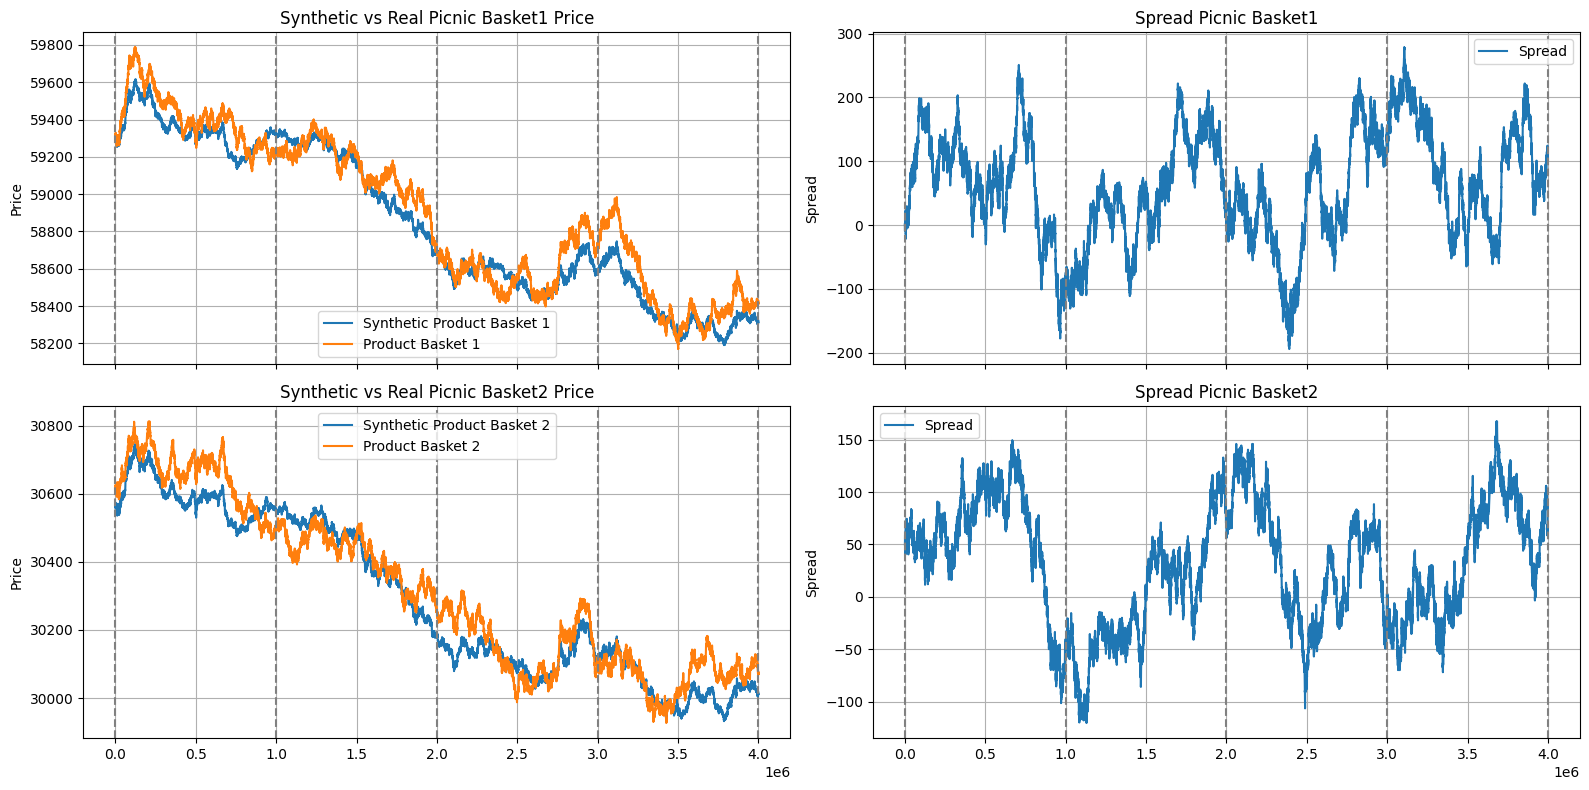

In [96]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), sharex=True)
for i in range(2):
    pb = combined[f"PICNIC_BASKET{i+1}"]["mid_price"]
    spb = combined[f"SPB{i+1}"]
    time = combined[f"PICNIC_BASKET{i+1}"]["timestamp"]

    axs[i, 0].plot(time, spb, label=f"Synthetic Product Basket {i+1}")
    axs[i, 0].plot(time, pb, label=f"Product Basket {i+1} ")
    axs[i, 0].legend()
    axs[i, 0].set_ylabel("Price")
    axs[i, 0].set_title(f"Synthetic vs Real Picnic Basket{i+1} Price")
    axs[i, 0].grid()

    spread = pb - spb
    axs[i, 1].plot(time, spread, label=f"Spread")
    axs[i, 1].set_ylabel("Spread")
    axs[i, 1].set_title(f"Spread Picnic Basket{i + 1}")
    axs[i, 1].legend()
    axs[i, 1].grid()

for day in days:
    day += 2
    axs[0, 0].axvline(x=day * 1E6, color="grey", linestyle="--")
    axs[0, 1].axvline(x=day * 1E6, color="grey", linestyle="--")
    axs[1, 0].axvline(x=day * 1E6, color="grey", linestyle="--")
    axs[1, 1].axvline(x=day * 1E6, color="grey", linestyle="--")


plt.tight_layout()
# plt.savefig("figures/price_spread_baskets.png")

In [86]:
pb1_bid = combined["PICNIC_BASKET1"]["bid_price_1"]
pb1_ask = combined["PICNIC_BASKET1"]["ask_price_1"]

spb1_bid = combined["SPB1_BUY"]
spb1_ask = combined["SPB1_SELL"]

spread_buy = pb1_ask - spb1_ask
spread_sell = pb1_bid - spb1_bid

In [87]:
buy_spread_mean = np.mean(spread_buy)
buy_spread_var = np.var(spread_buy) 
sell_spread_mean = np.mean(spread_sell)
sell_spread_var = np.var(spread_sell)
print(f"Buy Spread mean: {buy_spread_mean}")
print(f"Buy Spread var: {buy_spread_var}")
print(f"Sell Spread mean: {sell_spread_mean}")
print(f"Sell Spread var: {sell_spread_var}")

Buy Spread mean: 72.0388
Buy Spread var: 7434.643294559999
Sell Spread mean: 49.449325
Sell Spread var: 7439.190382044375


In [88]:
# 1. Welford's Online Algorithm
class WelfordStatsWithPriors:
    def __init__(self, initial_mean=None, initial_variance=None, initial_count=10):
        self.n = initial_count if initial_mean is not None else 0
        self.mean = initial_mean if initial_mean is not None else 0.0
        self.M2 = initial_variance * initial_count if initial_variance is not None else 0.0
        
    def update(self, x):
        self.n += 1
        delta = x - self.mean
        self.mean += delta / self.n
        delta2 = x - self.mean
        self.M2 += delta * delta2
        
    def get_mean(self):
        return self.mean
    
    def get_std(self):
        return np.sqrt(self.M2 / self.n if self.n > 1 else 1.0)

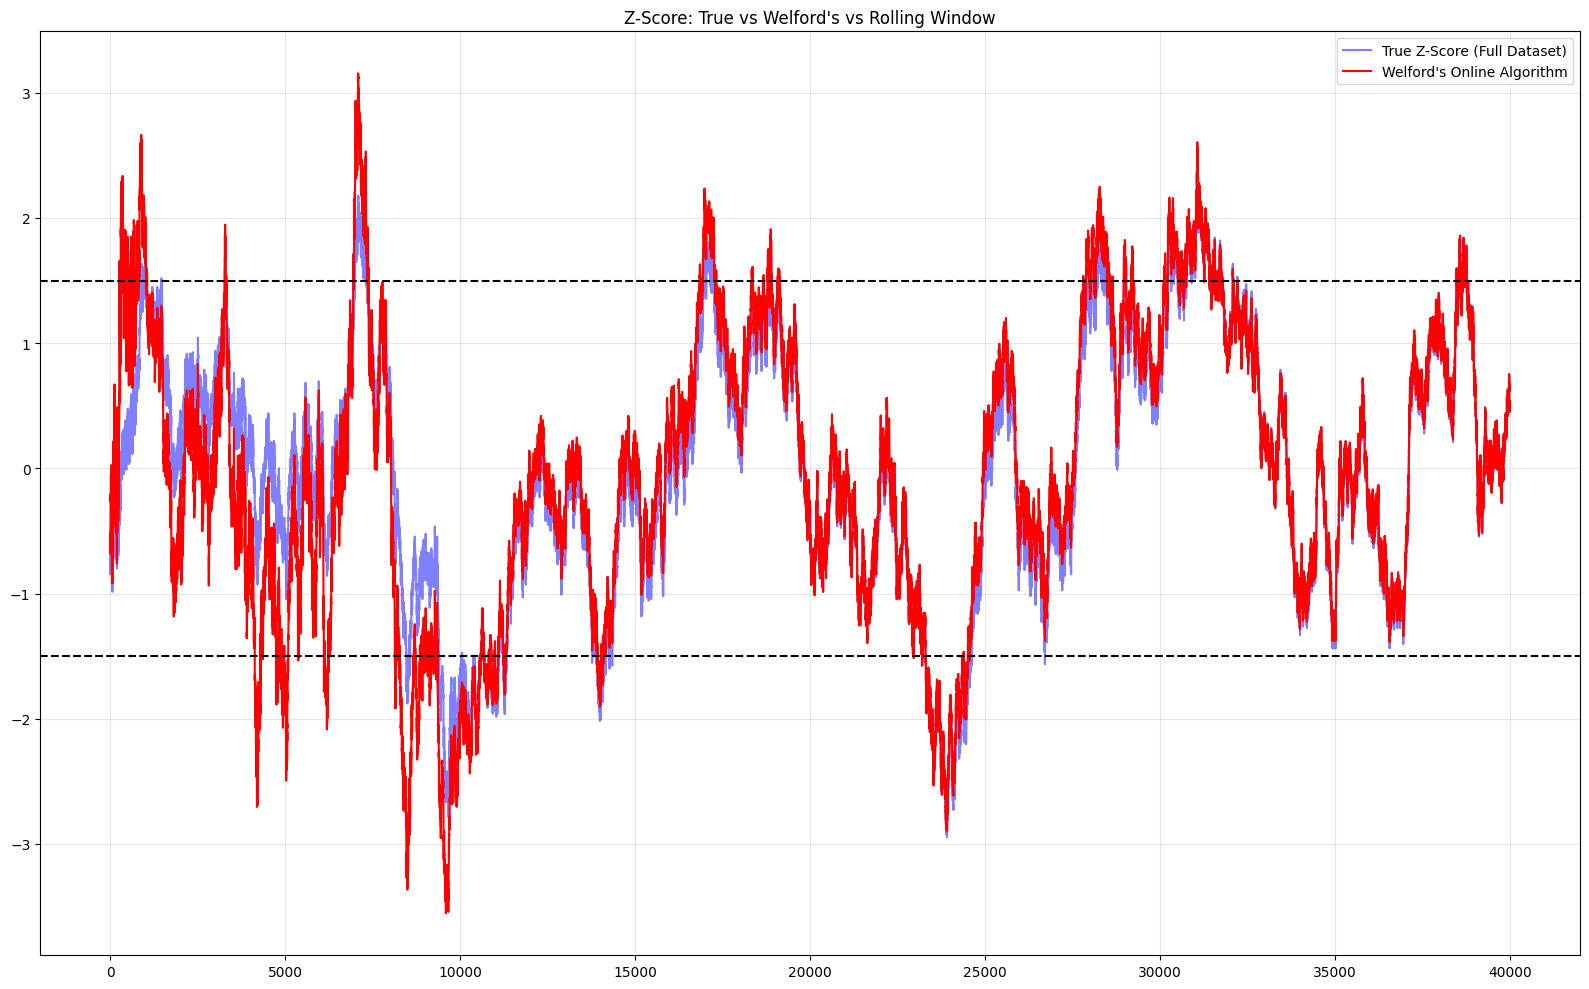

Number of signals (z-score >= 1.5):
True Z-Score: 5811
Welford Z-Score: 8059


In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

z_score_buy = (spread_buy - buy_spread_mean) / buy_spread_var**0.5

# Initialize our statistics calculators
N = 10
welford_stats = WelfordStatsWithPriors(buy_spread_mean, buy_spread_var, N)


# Calculate z-scores for each method
welford_z_scores = []
converge_window = 10
# Process the data
for i, spread in enumerate(spread_buy):
    # Update statistics
    welford_stats.update(spread)
    
    # Calculate z-scores
    if welford_stats.n > converge_window:  # Ensure some minimum data points
        welford_z = (spread - welford_stats.get_mean()) / welford_stats.get_std()
        welford_z_scores.append(welford_z)
    else:
        welford_z_scores.append(np.nan)


# Create dataframe for plotting
df = pd.DataFrame({
    'spread': spread_buy,
    'true_z_score': z_score_buy,
    'welford_z_score': welford_z_scores,
})

# Plot the results
fig, axes = plt.subplots(1, 1, figsize=(16, 10))

# Plot 2: True Z-Score vs Welford
axes.plot(df['true_z_score'], label='True Z-Score (Full Dataset)', color='blue', alpha=0.5)
axes.plot(df['welford_z_score'], label="Welford's Online Algorithm", color='red')
axes.axhline(y=1.5, color='black', linestyle='--')
axes.axhline(y=-1.5, color='black', linestyle='--')
axes.set_title("Z-Score: True vs Welford's vs Rolling Window")
axes.legend()
axes.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

# Print some statistics about signal generation
signals_true = (abs(df['true_z_score']) >= 1.5).sum()
signals_welford = (abs(df['welford_z_score']) >= 1.5).sum()

print("Number of signals (z-score >= 1.5):")
print(f"True Z-Score: {signals_true}")
print(f"Welford Z-Score: {signals_welford}")